In [1]:
import torch
from R_network_mm import RNet
import json
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

def compute_PSNR(img, imclean, data_range):
    Img = img.data.cpu().numpy().astype(np.float32)
    Iclean = imclean.data.cpu().numpy().astype(np.float32)
    PSNR = compare_psnr(Iclean[0,:,:,:], Img[0,:,:,:], data_range=data_range)
    return PSNR
    

In [3]:
exp = "exps/sigma25/64_2_7_1e-3_majorized"
#exp = "exps/sigma_25_64_4_3_deq_shared/AdpReg_ccvcvx"
path_ckp = exp + "/checkpoints/checkpoint_best_epoch.pth"
path_config = exp + "/config.json"
device = 'cuda:1'
config = json.load(open(path_config))
ckp = torch.load(path_ckp, map_location={'cuda:0':device,'cuda:1':device,'cuda:2':device,'cuda:3':device})

model = RNet(config['model_params'])
model.to(device)
model.load_state_dict(ckp['state_dict'])


model.W2.W1.weight.data = model.sumtoone(model.W2.W1.weight)
for i, _ in enumerate(model.W2.W1s): 
    model.W2.W1s[i].weight.data = model.sumtoone(model.W2.W1s[i].weight)


model.W1.W1.weight.data = model.zeromean(model.W1.W1.weight)
for i, _ in enumerate(model.W1.W1s): 
    model.W1.W1s[i].weight.data = model.zeromean(model.W1.W1s[i].weight)

In [4]:
from matplotlib import pyplot as plt
import numpy as np

np.random.seed(2023)

image = np.load('fig_data/img_clean.npy')
noisy_im = np.load('fig_data/img_noisy.npy')

x = torch.from_numpy(image)[np.newaxis, np.newaxis, :, :].to(device).float()
y = torch.from_numpy(noisy_im)[np.newaxis, np.newaxis, :, :].to(device).float()

In [5]:
print(model.lmbda)
import pandas as pd
val_data = pd.read_csv(f"{'denoise_val_results'}/validation_scores_{'sigma_25_mm_valid'}.csv").reset_index(drop=True)
p1 = val_data.loc[val_data["psnr"].idxmax()]["p1"]

model.lmbda = torch.nn.Parameter(torch.ones(1, 1).to(device) * p1)


Parameter containing:
tensor([[0.0011]], device='cuda:1', requires_grad=True)


[0.001, 0.00039810717055349724, 0.00015848931924611134, 6.309573444801933e-05, 2.51188643150958e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05]


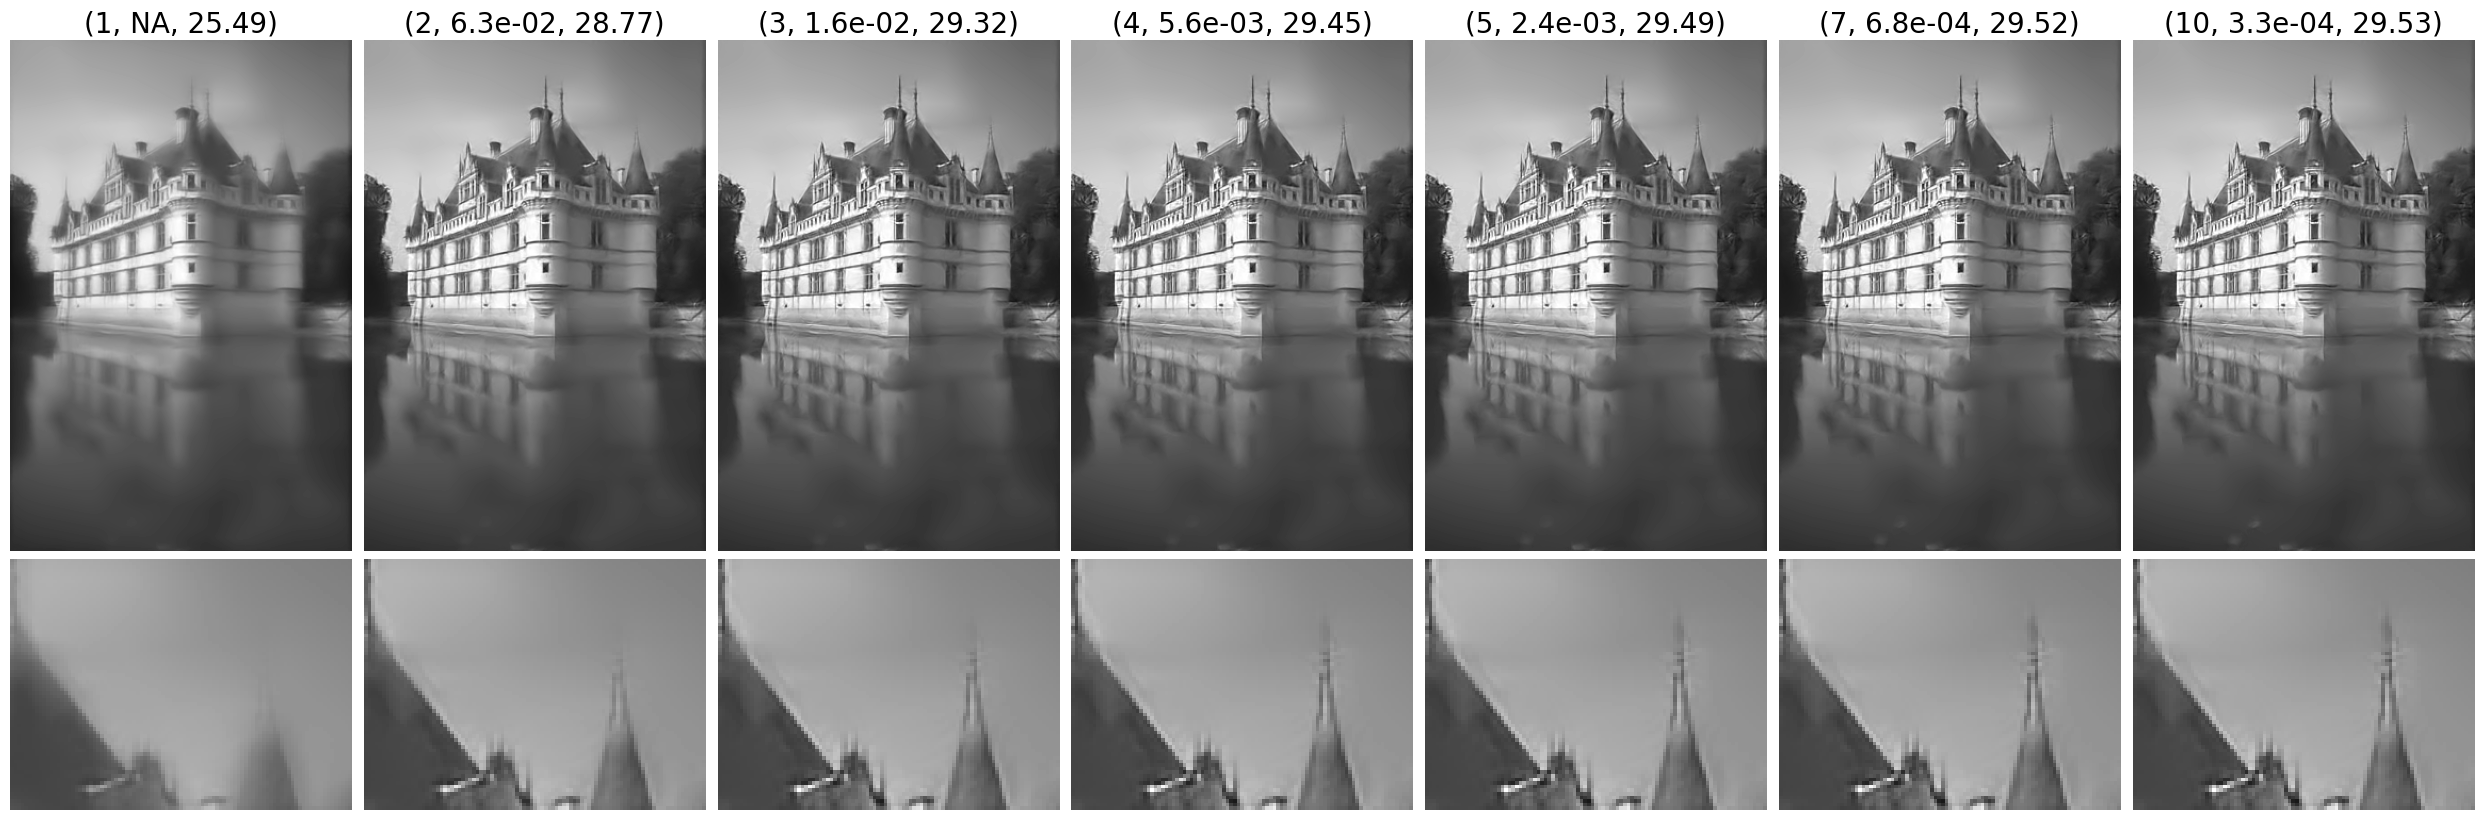

In [6]:
s = 1e-3
n = 5
e = 1e-5
q = (e/s) ** (1/n)
tols = [s * q**(i) for i in range(n+1)]
n_out = 10

for _ in range(n_out-(n+1)):
    tols.append(e)
print(tols)

with torch.no_grad(): 
    loss_list = list()
    h= 80
    w = 5
    r = image.shape[0]/image.shape[1]
    fig, ax = plt.subplots(2, 7, figsize=(7 * w, 2*w), gridspec_kw={"width_ratios": 7*[1], "height_ratios": [1, 1/r*70/95]})
    # plt.subplots_adjust(wspace=-0.35, hspace=0.02)
    plt.subplots_adjust(wspace=-0.4, hspace=0.02)
    n_in = 500  
    #tol= 1e-4 #1e-4 
    broken = False

    model.eigenimage = model.eigenimage.to(y.device)
    lip, model.eigenimage = model.W1.cal_lip(model.eigenimage, 4)
    model.alpha = 1 / (lip)
    c_k = model.prox_denoise_no_mask(y, y, n_in, tols[0])
    subfig = 1
    ax[0, 0].imshow(c_k[0, 0].cpu().detach(), cmap='gray', vmin=0, vmax=1)
    psnr = np.round(compute_PSNR(c_k, x, 1), 2)
    #plt.colorbar()
    ax[0, 0].axis('off')
    tt = '(' + str(1) + ', NA, ' + str(psnr) + ')'
    ax[0, 0].set_title(tt, fontsize=20)
    r = image.shape[0]/image.shape[1]
    ax[1, 0].imshow(c_k[0, 0, 55:125, 185:280].cpu().detach(), cmap='gray', vmin=0, vmax=1)
    ax[1, 0].axis('off')
    for kk in range(n_out - 1):   
        model.cal_mask(c_k)
        c_k_new = model.prox_denoise_with_mask(y, c_k, n_in, tols[kk+1])
        
        rel_err_out = (torch.norm(c_k - c_k_new) / torch.norm(c_k)).item() 
        c_k = c_k_new

        sc = "{:0.1e}".format(rel_err_out)
        if (kk < 4) or (kk==5) or (kk == 8):
            ax[0, subfig].imshow(c_k[0, 0].cpu().detach(), cmap='gray', vmin=0, vmax=1)
            psnr = np.round(compute_PSNR(c_k, x, 1), 2)
            #plt.colorbar()
            ax[0, subfig].axis('off')
            tt = '(' + str(kk+2) + ', '+sc+', ' + str(psnr) + ')'
            ax[0, subfig].set_title(tt, fontsize=20)
            ax[1, subfig].imshow(c_k[0, 0, 55:125, 185:280].cpu().detach(), cmap='gray', vmin=0, vmax=1)
            ax[1, subfig].axis('off'); subfig = subfig + 1


plt.savefig('fig_data/mmrr_denosing.pdf', bbox_inches="tight")
plt.show()

[0.001, 0.00039810717055349724, 0.00015848931924611134, 6.309573444801933e-05, 2.51188643150958e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05]


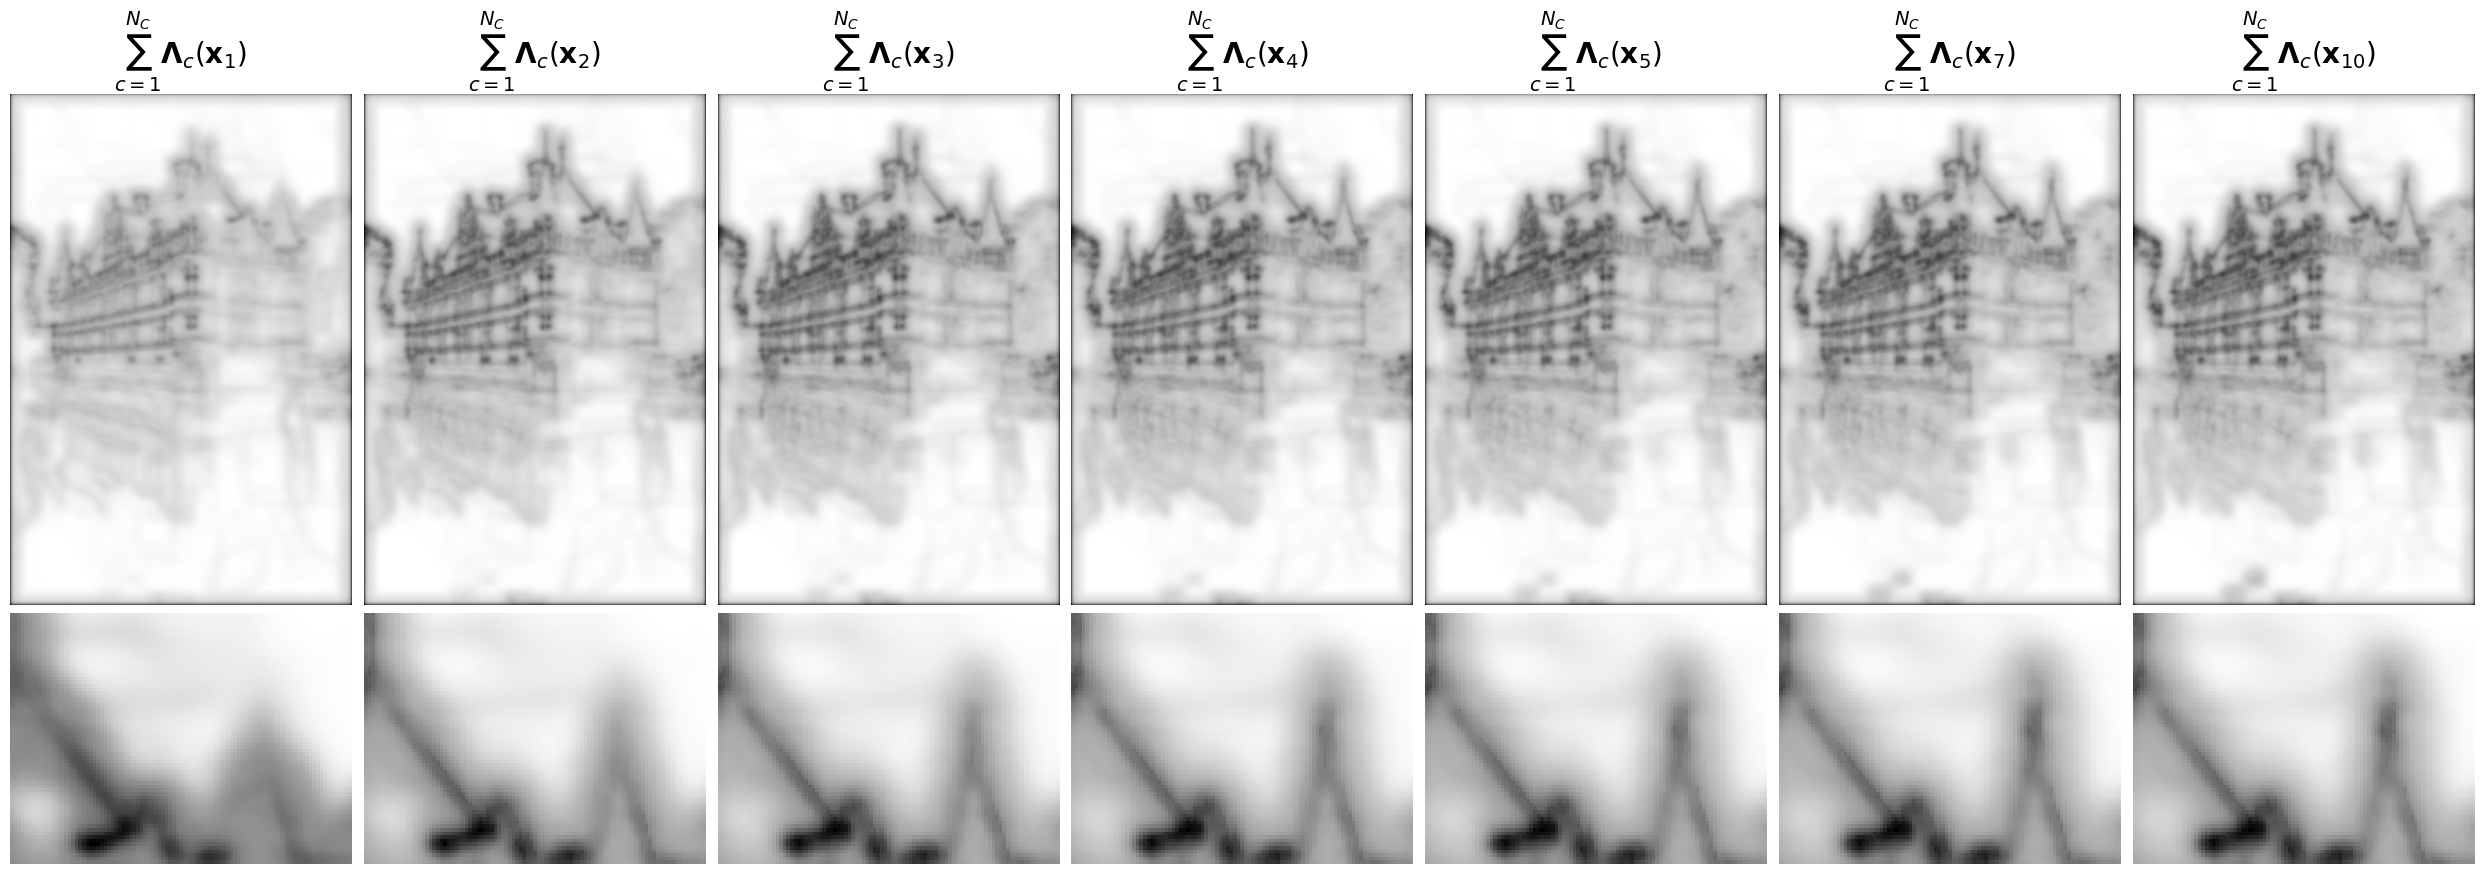

In [7]:
s = 1e-3
n = 5
e = 1e-5
q = (e/s) ** (1/n)
tols = [s * q**(i) for i in range(n+1)]
n_out = 11

for _ in range(n_out-(n+1)):
    tols.append(e)
print(tols)

with torch.no_grad(): 
    loss_list = list()
    h= 80
    w = 5
    r = image.shape[0]/image.shape[1]
    fig, ax = plt.subplots(2, 7, figsize=(7 * w, 2*w), gridspec_kw={"width_ratios": 7*[1], "height_ratios": [1, 1/r*70/95]})
    # plt.subplots_adjust(wspace=-0.35, hspace=0.02)
    plt.subplots_adjust(wspace=-0.4, hspace=0.02)
    n_in = 500  
    #tol= 1e-4 #1e-4 
    broken = False

    model.eigenimage = model.eigenimage.to(y.device)
    lip, model.eigenimage = model.W1.cal_lip(model.eigenimage, 4)
    model.alpha = 1 / (lip)
    c_k = model.prox_denoise_no_mask(y, y, n_in, tols[0])
    subfig = 0
    for kk in range(n_out - 1):   
        model.cal_mask(c_k)
        c_k_new = model.prox_denoise_with_mask(y, c_k, n_in, tols[kk+1])
        
        rel_err_out = (torch.norm(c_k - c_k_new) / torch.norm(c_k)).item() 
        c_k = c_k_new

        sc = "{:0.1e}".format(rel_err_out)
        if (kk < 5) or (kk==6) or (kk == 9):
            msk = model.mask[0, :, :, :].mean(dim=0).cpu().detach().numpy()
            ax[0, subfig].imshow(msk, cmap='gray')
            psnr = np.round(compute_PSNR(c_k, x, 1), 2)
            #plt.colorbar()
            ax[0, subfig].axis('off')
            tt = '$\sum_{c=1}^{N_C} \mathbf{\Lambda}_c({\mathbf{x}}_{'+str(kk+1)+'})$'
            ax[0, subfig].set_title(tt, fontsize=20)
            ax[1, subfig].imshow(msk[55:125, 185:280], cmap='gray')
            ax[1, subfig].axis('off'); subfig = subfig + 1


plt.savefig('fig_data/mmrr_masks.pdf', bbox_inches="tight")
plt.show()

In [8]:
im_denoised_sdrr = c_k
np.save("fig_data/denoised_castle_mdrr_25.npy", im_denoised_sdrr[0, 0].cpu())

In [9]:
c_k = torch.from_numpy(np.load("fig_data/denoised_castle_mdrr_25.npy"))[None, None, :, :].to(device)
model.cal_mask(c_k)

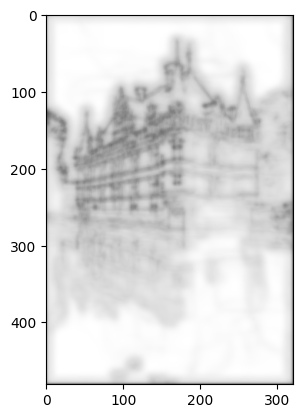

In [10]:
saved = model.mask[0, :, :, :].mean(dim=0).cpu().detach().numpy()
plt.imshow(saved, cmap='gray', vmin=0, vmax=1)
plt.show()
np.save("fig_data/mask_average_mdrr_25.npy", saved)

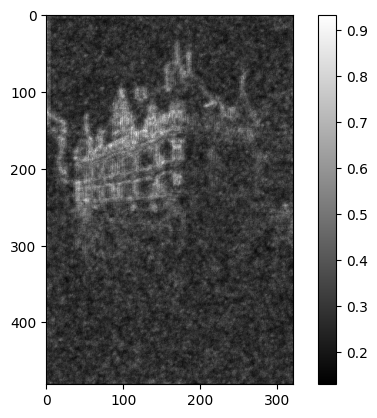

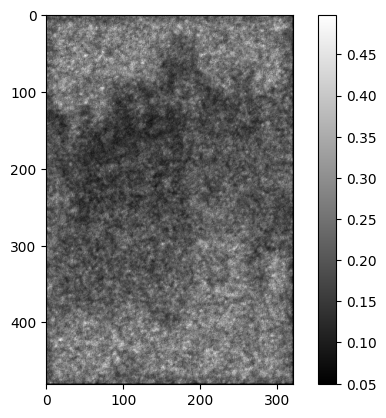

In [11]:
Ly = torch.abs(model.L(y, state='nomask'))[0, ...].mean(dim=0).cpu().detach().numpy()
Ly_masked = torch.abs(model.L(y))[0, ...].mean(dim=0).cpu().detach().numpy()
plt.imshow(Ly, cmap='gray')
plt.colorbar()
plt.show()
plt.imshow(Ly_masked, cmap='gray')
plt.colorbar()
plt.show()
np.save("fig_data/Ly_mdrr_25.npy", Ly)
np.save("fig_data/Ly_masked_mdrr_25.npy", Ly_masked)